## 1. Single-Server Queuing System

### Single Server System

- Arrivals are drawn from an infinite calling population
- Unlimited waiting room capacity
- Customers will be served in the order of their arrival (fist come first serve basis)
- Arrivals occur one at a time in a random fashion (distribution times in table below)
- All arrivals are eventually served and service times are also random (service times in table below)
- After service, all customers return to the calling population

State variables:
1. The number of customers in the system
2. The status of the server (whether busy or idle)
3. The time of the next arrival

***Event*** A situation that causes the state of the system to change instantaneously.
- Arrival into the system & departure from the system at the completion of service.
- In the simulation, these events will be scheduled to take place at certain points in time
- All information about events is maintained in a list called the ***event list***.
    - Keeps track of the type of events scheduled
    - Keeps track of **the time at which these events are scheduled to take place** ("clock time")

#### The System

***Next-Event Time-Advance Mechanism***
- First event (arrival) takes place at clock time 0
    - Server is idle and enters service immediately
    - Arrivals at other points in time = idle or busy server.
    - If idle, customer enters service; if busy, customer joins the waiting line

- Schedule the departure of the first customer
    - random generation of a service time from the service time distribution:

    $$ \text{Departure Time} = \text{clock time now} + \text{generated service time} $$

- Schedule the next arrival into the system via random generation of an interarrival time from the interarrival time distribution and setting the arrival time as:

    $$ \text{Arrival Time} = \text{clock time now} + \text{generated interarrival time}$$

    - e.g. service time of 2 mins means the departure time for the customer will be set at clock time 2

- The above events and their scheduled times are maintained on the event list, and we proceed accordingly.

In the **Next-Event Time-Advance**  method, the event determines the advancing of the clock time; in the **Fixed-Increment Time-Advance** method, we move with fixed clock times.

### The Simulation

\begin{aligned}
&TM =  \text{clock time of the simulation}\\
&AT =  \text{scheduled time of the next arrival}\\
&DT =  \text{scheduled time of the next departure}\\
&SS =  \text{status of the server (1 = busy, 0 = idle)}\\
&WL =  \text{length of the waiting line}\\
&MX =  \text{length (in time units) of a simulation run}
\end{aligned}

Interarrival Time Distribution
Interarrival Time (minutes)|Probability
-|-
1|0.20
2|0.30
3|0.35
4|0.15

Service Time Distrubtion
Service Time (Minutes)|Probability
-|-
1|0.35
2|0.40
3|0.25

1. **Initialize Variables**: 
   - Set `TM`=0, `AT`=0, `DT`=9999, `SS`=0 (idle), `WL`=0.

2. **Start Simulation**: 
   - Compare `AT` and `DT` to determine the next event.

3. **Process Arrival**:
   - If `AT` < `DT`, set `TM` = `AT`.
   - If `SS` = 0 (idle), customer enters service: 
     - Set `SS` = 1.
     - Generate service time (`ST`).
     - Set `DT` = `TM` + `ST`.
   - If `SS` = 1 (busy), customer joins queue:
     - Increment `WL`.
   - Schedule next arrival:
     - Generate interarrival time (`IT`).
     - Set `AT` = `TM` + `IT`.

4. **Process Departure**:
   - If `DT` < `AT`, set `TM` = `DT`.
   - If `WL` > 0, serve next in line:
     - Decrement `WL`.
     - Generate `ST`.
     - Set `DT` = `TM` + `ST`.
   - If `WL` = 0:
     - Set `SS` = 0.
     - Reset `DT` = 9999.

5. **Loop**:
   - Repeat steps 2-4, updating event list and variables as events are processed.

6. **Termination Condition**:
   - Check if `TM` ≥ `MX`. If true, stop simulation; otherwise, continue.

7. **Output Statistics** (not detailed in text):
   - Calculate and output performance measures as needed.

In [348]:
import random
import pandas as pd


i_d = {1: 0.2, 2: 0.3, 3: 0.35, 4: 0.15}
s_d = {1: 0.35, 2: 0.4, 3: 0.25}

def gen_customer_data(n, i_d, s_d):

    def gen_times(d):
        r = random.random()
        c = 0
        for i, p in d.items():
            c += p
            if c >= r:
                return i

    c = pd.DataFrame({
        "customer": list(range(1, n+1)),
        "interarrival_time": [gen_times(i_d) for _ in range(1, n+1)],
        "service_time": [gen_times(s_d) for _ in range(1, n+1)],
    })

    c["interarrival_time"] = c["interarrival_time"].shift().fillna(0)
    c["service_time"] = c["service_time"].shift(-1).fillna(0)

    return c.set_index("customer").astype(int)


def SimQueue(n_customers, i_d, s_d, random_seed=42):
    random.seed(random_seed)
    c = gen_customer_data(n_customers, i_d, s_d)

    q = []
    customer, SS, WL, TM, AT, DT = 0, 0, 0, 0, 0, 9999
    departures = 0
    events = [["-", "initialization", SS, WL, TM, AT, DT]]

    while departures < n_customers:
        if AT > DT:
            TM = DT
            event = "departure"
            customer_departing = q.pop(0)
            if WL > 0:
                WL -= 1
                next_customer = min(customer_departing + 1, n_customers)
                ST = c.loc[next_customer, "service_time"]
                DT = TM + ST
            else:
                SS = 0
                DT = 9999
            departures += 1
            events.append([customer_departing, event, SS, WL, TM, AT, DT])
        else:
            TM = AT
            event = "arrival"
            customer += 1
            q.append(customer)
            if SS == 0:
                SS = 1
                ST = c.loc[customer, "service_time"]
                DT = TM + ST
            else:
                WL += 1
            next_customer = min(customer + 1, n_customers)
            IT = c.loc[next_customer, "interarrival_time"]
            AT = TM + IT
            events.append([customer, event, SS, WL, TM, AT, DT])

    columns = ["customer", "event", "service_status", "waiting_line", "clock_time", "arrival_time", "departure_time"]
    events = pd.DataFrame(events, columns=columns)
    events.index.name = "end_of_event"
    events = events.sort_index()
    return c, events

customer_data, sim = SimQueue(10, i_d, s_d, random_seed=50)

In [349]:
sim

,customer,event,service_status,waiting_line,clock_time,arrival_time,departure_time
end_of_event,,,,,,,
0,-,initialization,0,0,0,0,9999
1,1,arrival,1,0,0,2,3
2,2,arrival,1,1,2,4,3
3,1,departure,1,0,3,4,6
4,3,arrival,1,1,4,7,6
5,2,departure,1,0,6,7,7
6,4,arrival,1,1,7,9,7
7,3,departure,1,0,7,9,8
8,4,departure,0,0,8,9,9999


## 2. Monte Carlo Simulation

Pierre’s Bakery bakes and sells French bread. Each morning, the bakery satisfies the demand for the day using freshly baked bread. Pierre’s can bake the bread only in batches of a dozen loaves each. Each loaf costs 25¢ to make. For simplicity, we assume that the total daily demand for bread also occurs in multiples of 12. Past data have shown that this demand ranges from 36 to 96 loaves per day. A loaf sells for 40¢, and any bread left over at the end of the day is sold to a charitable kitchen for a salvage price of 10¢/loaf. If demand exceeds supply, we assume that there is a lost-profit cost of 15¢/loaf (because of loss of goodwill, loss of customers to competitors, and so on). The bakery records show that the daily demand can be categorized into three types: high, average, and low. These demands occur with probabilities of .30, .45, and .25, respectively. The distribution of the demand by categories is given in Table 7. Pierre’s would like to determine the optimal number of loaves to bake each day to maximize profit (revenues − salvage revenues − cost of bread − cost of lost profits).


Demand Distribution by Demand Categories

| Demand | High | Average | Low  |
|--------|------|---------|------|
| 36     | .05  | .10     | .15  |
| 48     | .10  | .20     | .25  |
| 60     | .25  | .30     | .35  |
| 72     | .30  | .25     | .15  |
| 84     | .20  | .10     | .05  |
| 96     | .10  | .05     | .05  |

Distribution of Demand Type

| Type of Demand | Probability | Cumulative Distribution | Random Number Ranges |
|----------------|-------------|-------------------------|----------------------|
| High           | .30         | .30                     | 00–29               |
| Average        | .45         | .75                     | 30–74               |
| Low            | .25         | 1.00                    | 75–99               |

Distribution by Demand Type

| Demand | High | Average | Low  |  Random Number Ranges (High) | Random Number Ranges (Average) | Random Number Ranges (Low) |
|--------|------|---------|------|-----------------------------|--------------------------------|----------------------------|
| 36     | .05  | .10     | .15  | 00–04                       | 00–09                          | 00–14                      |
| 48     | .15  | .30     | .40  | 05–14                       | 10–29                          | 15–39                      |
| 60     | .40  | .60     | .75  | 15–39                       | 30–59                          | 40–74                      |
| 72     | .70  | .85     | .90  | 40–69                       | 60–84                          | 75–89                      |
| 84     | .90  | .95     | .95  | 70–89                       | 85–94                          | 90–94                      |
| 96     | 1.00 | 1.00    | 1.00 | 90–99                       | 95–99                          | 95–99                      |


In [298]:
import pandas as pd

demand_dist = pd.DataFrame([
    [36, 0.05, 0.10, 0.15],
    [48, 0.10, 0.20, 0.25],
    [60, 0.25, 0.30, 0.35],
    [72, 0.30, 0.25, 0.15],
    [84, 0.20, 0.10, 0.05],
    [96, 0.10, 0.05, 0.05]
], columns=['Demand', 'High', 'Average', 'Low']).set_index("Demand")

demand_type_dist = pd.DataFrame([
    ["High",    0.30],
    ["Average", 0.45],
    ["Low",     0.25]
], columns=["Type of Demand", "Probability"]).set_index('Type of Demand')

print(demand_dist, "\n\n", demand_type_dist)

        High  Average   Low
Demand                     
36      0.05     0.10  0.15
48      0.10     0.20  0.25
60      0.25     0.30  0.35
72      0.30     0.25  0.15
84      0.20     0.10  0.05
96      0.10     0.05  0.05 

                 Probability
Type of Demand             
High                   0.30
Average                0.45
Low                    0.25


### Step 1. Generate Demand Type

Begin by using `demand_type_dist` to generate a type of demand based on their cumulative probability distribution. The `gen_demand_type` function achieves this.

In [299]:
import random

def gen_demand_type(demand_type_dist):

    r = random.random()
    c = 0
    for i, p in enumerate(demand_type_dist.squeeze().values):
        c += p
        if c >= r:
            return demand_type_dist.index[i]
        
demand_type = gen_demand_type(demand_type_dist)

demand_type

'Low'

### Step 2. Generate Actual Demand

After we get the demand type via `gen_demand_type`, we generate the actual demand for the day based on the type of demand generated. In the below function if we've generated an `'Average` demand type and the cumulative probability `c` adds up to greater than or equal to `r = 0.6` (for example), we would generate a demand value of 60.

In [300]:
def gen_demand(demand_type, demand_dist):
    
    demand_dist_cat = demand_dist[demand_type]

    r = random.random()
    c = 0

    for i, p in enumerate(demand_dist_cat.values):
        c += p
        if c >= r:
            return demand_dist_cat.index[i]
        
demand = gen_demand(demand_type, demand_dist)

demand

96

### Step 3. Build a Single-Iteration Simulation

Note here that how much we make per day based on whether each day's generated demand exceeds, is equal to, or is below the daily supply (which is the number of bread loaves determined by the policy).

In [496]:
random.seed(10)

def check_demand(demand, supply):
    if supply > demand:
        return "SR"
    elif supply < demand:
        return "LP"
    else:
        return "M"

def SimBakery(n_days, policy_amt):
    sim = pd.DataFrame({
        "Day": [_ for _ in range(1, n_days + 1)],
        "Supply": [policy_amt] * n_days,
        "Demand": [gen_demand(gen_demand_type(demand_type_dist), demand_dist) for _ in range(n_days)]
,
    }).set_index("Day")

    sim["Profit"] = sim["Demand"].apply(
        lambda x: x*0.4 - x*0.25 if check_demand(x, policy_amt) == "M" \
            else x*0.4 + (policy_amt-x)*0.1 - policy_amt*0.25 if check_demand(x, policy_amt) == "SR" \
                else policy_amt*0.4 - (x-policy_amt)*0.15 - policy_amt*0.25
    )

    return sim, sim["Profit"].mean()

n_days = 10
policy_amt = 60

sim, avg_profit = SimBakery(n_days, policy_amt)

display(sim)
print(f"Average Profit: ${avg_profit:,.2f}")

,Supply,Demand,Profit
Day,,,
1,60,60,9.0
2,60,48,5.4
3,60,72,7.2
4,60,48,5.4
5,60,60,9.0
6,60,96,3.6
7,60,36,1.8
8,60,60,9.0
9,60,48,5.4


Average Profit: $6.48


### Step 4. Build a multi-iteration Simulation and Find Best Policy

We now take the single-iteration simulation and test it with the different demand values to determine the best policy (i.e. the optimal number of loaves of bread to bake each day, or the number of loaves of bread that yields the highest profit). We'll use an `n_days = 10000` for a more comprehensive simulation per policy.

In [374]:
random.seed(10)

demands = [36, 48, 60, 72, 84, 96]
policies = {d: [] for d in demands}
n_days = 10_000

for policy in policies:
    _, avg_profit = SimBakery(n_days, policy)
    policies[policy].append(avg_profit)

policies = pd.DataFrame(policies, index=["Avg. Profit"]).T
policies.index.name = "Demand"

policies.idxmax()[0], f"${policies.max()[0]:,.2f}"

(72, '$6.90')

In [375]:
policies

,Avg. Profit
Demand,
36,1.25514
48,4.33980
60,6.39918
72,6.89922
84,6.11226
96,4.60908


## Problems

### 1. 
Simulate the single-server queuing system for the first 25 departures from the system to develop an estimate for the expected time in the waiting line. Is this a reasonable estimate? Explain.

In [353]:
import numpy as np
from tqdm.auto import tqdm
n = 25

exp_wait_times = []
for seed in tqdm(range(1_000)):
    _, sim = SimQueue(25, i_d, s_d, random_seed=seed)
    customers_waiting = sim[(sim["waiting_line"].gt(0)) & (sim["event"] == "arrival")]
    customers_in_line = sim[sim["customer"].isin(customers_waiting["customer"])].sort_values(by=["customer", "clock_time"]).reset_index()

    wait_times = []
    for i in range(1, len(customers_in_line), 2):
        wait_times.append(customers_in_line.loc[i-1:i][["customer","clock_time"]].diff().values[1][1])
    if seed == 0:
        mean_wait_time = np.mean(wait_times)
    exp_wait_times.append(np.mean(wait_times))

  0%|          | 0/1000 [00:00<?, ?it/s]

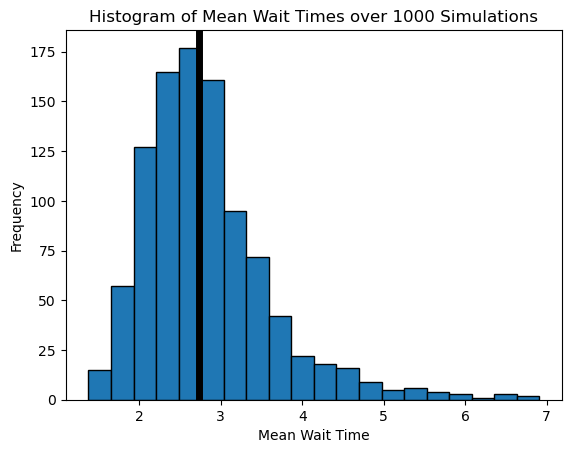

In [363]:
import matplotlib.pyplot as plt

plt.hist(exp_wait_times, bins=20, edgecolor='black')
plt.axvline(mean_wait_time, color="black", linewidth=5)
plt.xlabel('Mean Wait Time')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Wait Times over 1000 Simulations')
plt.show()

### 2.

Perform the simulation for Pierre’s Bakery for 25 more days (days 16 through 40) for policy C in Table 11. Compare the answer with the results in the table.

In [373]:
random.seed(10)

sim, avg_profit = SimBakery(40, 60)
print(f"${avg_profit:,.2f}")
display(sim.tail(25))

$6.17


,Supply,Demand,Profit
Day,,,
16,60,48,5.4
17,60,84,5.4
18,60,60,9.0
19,60,36,1.8
20,60,72,7.2
21,60,60,9.0
22,60,36,1.8
23,60,72,7.2
24,60,60,9.0


### 3. 

Consider the simplest form of craps. In this game, we roll a pair of dice. If we roll a 7 or an 11 on the first throw, we win right away. If we roll a 2 or a 3 or a 12, we lose right away. Any other total (that is, 4, 5, 6, 8, 9, or 10) gives us a second chance. In this part of the game, we keep rolling the dice until we get either a 7 or the total rolled on the first throw. If we get a 7, we lose. If we roll the same total as on the first throw, we win. Assuming that the dice are fair, develop a simulation experiment to determine what percentage of the time we win.

In [495]:
class Dice:

    def __init__(self):
        self.probs = {i: 1/6 for i in range(1, 7)}

    def _roll(self):
        r = random.random()
        c = 0
        for i, p in self.probs.items():
            c += p
            if c >= r:
                return i
            
    def roll(self, n=1):
        if n == 1:
            return self._roll()

        else:
            return [self._roll() for _ in range(n)]

class Craps:
    def __init__(self):
        self.die = Dice()

    def play(self):

        rolls_sum_1 = np.sum(self.die.roll(2))

        if rolls_sum_1 == 7 or rolls_sum_1 == 11:
            return rolls_sum_1, "roll 1", "win"
        
        elif rolls_sum_1 == 2 or rolls_sum_1 == 12:
            return rolls_sum_1, "roll 1", "lose"

        else:
            i = 2
            while True:
                rolls_sum_2 = np.sum(self.die.roll(2))
                if rolls_sum_2 == 7:
                    return rolls_sum_2, f"roll {i}", "lose"
                elif rolls_sum_2 == rolls_sum_1:
                    return rolls_sum_2, f"roll {i}", "win"
                i += 1

def SimCraps(n):
    craps = Craps()
    wins = sum(craps.play()[-1] == "win" for _ in range(n))
    return wins / n

print(f"{SimCraps(100_000)*100:,.2f}%")

50.93%


### 4.

Tankers arrive at an oil port with the distribution of interarrival times shown below. The port has two terminals, A and B. Terminal B is newer and therefore more efficient than terminal A. The time it takes to unload a tanker depends on the tanker’s size. A supertanker takes 4 days to unload at terminal A and 3 days at terminal B. A midsize tanker takes 3 days at terminal A and 2 days at terminal B. The small tankers take 2 days at terminal A and 1 day at terminal B. Arriving tankers form a single waiting line in the port area until a terminal becomes available for service. Service is given on an FCFS basis. The type of tankers and the frequency with which they visit this port is given by the distribution in Table 13. Develop a simulation model for this port. Compute such statistics as the average number of tankers in port, the average number of days in port for a tanker, and the percentage of idle time for each of the terminals. (Hint: Use the flowchart in Figure 4 and modify it for a multiserver queuing system.)

Interarrival Times|Probability|-|Type of Tanker|Probability
-|-|-|-|-
1|0.20|-|Supertanker|0.40
2|0.25|-|Midsize tanker|0.35
3|0.35|-|Small tanker|0.25
4|0.15|-|
5|0.05|-|